1. Importação das Bibliotecas Necessárias

Importamos as bibliotecas essenciais para manipulação de dados, visualização, pré-processamento, construção e treinamento do modelo, e tratamento de feriados.

In [41]:
# Importação de bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Bibliotecas para pré-processamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# Bibliotecas para construção e treinamento do modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

# Biblioteca para lidar com feriados
import holidays

# Ignorar avisos para uma saída mais limpa
import warnings
warnings.filterwarnings('ignore')

2. Carregamento e Inspeção dos Dados

Carregamos o arquivo CSV contendo os dados de vendas e realizamos uma inspeção inicial para entender a estrutura dos dados.

In [42]:
# Definir o caminho do arquivo CSV
csv_path = '../data/dados_transacao_26173.csv'  # Atualize o caminho conforme necessário

# Carregar o CSV
df = pd.read_csv(csv_path)

# Converter a coluna 'Data' para datetime
df['Data'] = pd.to_datetime(df['Data'], format='%Y-%m-%d')

# Exibir as primeiras linhas do dataset
print("Primeiras linhas do dataset:")
display(df.head())

# Informações gerais sobre o dataset
print("\nInformações gerais do dataset:")
print(df.info())

# Estatísticas descritivas
print("\nEstatísticas descritivas:")
display(df.describe())

Primeiras linhas do dataset:


,CodigoVenda,Data,DataHora,Status,VendaCancelada,TotalPedido,DescontoGeral,AcrescimoGeral,TotalCusto,CodigoProduto,...,ValorCustoGerencial,CodigoFornecedor,CodigoKitPrincipal,ValorKitPrincipal,EmPromocao,DiaDaSemana,Mes,Dia,Feriado,VesperaDeFeriado
0,2263035,2019-01-02,2019-01-02 08:36:25,f,0,58.08,0.0,0.0,27.30,26173,...,1.5,0,0,0,0,2,1,2,0,0
1,2263063,2019-01-02,2019-01-02 09:01:27,f,0,40.05,0.0,0.0,29.45,26173,...,1.5,0,0,0,0,2,1,2,0,0
2,2263067,2019-01-02,2019-01-02 09:06:07,f,0,34.75,0.0,0.0,26.94,26173,...,1.5,0,0,0,0,2,1,2,0,0
3,2263151,2019-01-02,2019-01-02 09:55:52,f,0,210.10,0.0,0.0,146.63,26173,...,1.5,0,0,0,0,2,1,2,0,0
4,2263159,2019-01-02,2019-01-02 10:01:20,f,0,96.72,0.0,0.0,60.43,26173,...,1.5,0,0,0,0,2,1,2,0,0



Informações gerais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117192 entries, 0 to 117191
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CodigoVenda          117192 non-null  int64         
 1   Data                 117192 non-null  datetime64[ns]
 2   DataHora             117192 non-null  object        
 3   Status               117192 non-null  object        
 4   VendaCancelada       117192 non-null  int64         
 5   TotalPedido          117190 non-null  float64       
 6   DescontoGeral        117192 non-null  float64       
 7   AcrescimoGeral       117192 non-null  float64       
 8   TotalCusto           117192 non-null  float64       
 9   CodigoProduto        117192 non-null  int64         
 10  Quantidade           117192 non-null  float64       
 11  ValorUnitario        117192 non-null  float64       
 12  ValorTotal           117192 non-null  fl

,CodigoVenda,Data,VendaCancelada,TotalPedido,DescontoGeral,AcrescimoGeral,TotalCusto,CodigoProduto,Quantidade,ValorUnitario,...,ValorCustoGerencial,CodigoFornecedor,CodigoKitPrincipal,ValorKitPrincipal,EmPromocao,DiaDaSemana,Mes,Dia,Feriado,VesperaDeFeriado
count,1.171920e+05,117192,117192.000000,117190.000000,117192.0,117192.0,117192.000000,117192.0,117192.000000,117192.000000,...,117192.000000,117192.000000,117192.0,117192.0,117192.000000,117192.000000,117192.000000,117192.000000,117192.000000,117192.000000
mean,3.542673e+06,2021-11-03 02:58:09.412246272,0.000734,220.880381,0.0,0.0,163.759094,26173.0,1.410600,2.249984,...,1.594766,14.557222,0.0,0.0,0.070696,3.355971,6.196182,15.685260,0.007603,0.054543
min,2.263035e+06,2019-01-02 00:00:00,0.000000,-249.980000,0.0,0.0,-181.330000,26173.0,-90.000000,-3.550000,...,0.600000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,3.020720e+06,2020-09-09 18:00:00,0.000000,56.462500,0.0,0.0,40.567500,26173.0,1.000000,1.950000,...,1.500000,0.000000,0.0,0.0,0.000000,2.000000,3.000000,8.000000,0.000000,0.000000
50%,3.522943e+06,2021-11-06 00:00:00,0.000000,133.545000,0.0,0.0,95.645000,26173.0,1.000000,2.110000,...,1.500000,0.000000,0.0,0.0,0.000000,4.000000,6.000000,16.000000,0.000000,0.000000
75%,4.128652e+06,2023-02-17 00:00:00,0.000000,289.540000,0.0,0.0,208.232500,26173.0,1.000000,2.790000,...,2.000000,0.000000,0.0,0.0,0.000000,5.000000,9.000000,24.000000,0.000000,0.000000
max,4.890548e+06,2024-08-27 00:00:00,1.000000,3660.680000,0.0,0.0,35127.070000,26173.0,364.000000,19.150000,...,3.000000,77545.000000,0.0,0.0,1.000000,6.000000,12.000000,31.000000,1.000000,1.000000
std,7.091584e+05,NaN,0.027080,255.111260,0.0,0.0,297.898729,0.0,2.207204,0.689172,...,0.497781,1062.373533,0.0,0.0,0.256317,1.915065,3.609532,8.935082,0.086863,0.227087


3. Pré-processamento dos Dados

Agregamos os dados por dia, criamos um range completo de datas para garantir que não haja datas faltantes e lidamos com valores ausentes. Também adicionamos lags das vendas anteriores para enriquecer o conjunto de features.

In [43]:
# Agregar os dados por dia
daily_df = df.groupby('Data').agg({
    'ValorUnitario': 'mean',  # Média do valor unitário por dia
    'Quantidade': 'sum'       # Quantidade total vendida por dia
}).reset_index()

# Exibir as primeiras linhas do dataframe agregado
print("\nPrimeiras linhas do dataframe agregado por dia:")
display(daily_df.head())

# Criar um range completo de datas
all_dates = pd.date_range(start=daily_df['Data'].min(), end=daily_df['Data'].max(), freq='D')
daily_df = daily_df.set_index('Data').reindex(all_dates).reset_index()
daily_df.rename(columns={'index': 'Data'}, inplace=True)

# Preencher valores ausentes
daily_df['Quantidade'].fillna(0, inplace=True)
daily_df['ValorUnitario'].interpolate(method='linear', inplace=True)
daily_df['ValorUnitario'].fillna(method='bfill', inplace=True)

# Confirmar a ausência de valores faltantes
print("\nValores faltantes após tratamento:")
print(daily_df.isnull().sum())

# Adicionar lags das vendas anteriores
for lag in range(1, 8):
    daily_df[f'Quantidade_Lag{lag}'] = daily_df['Quantidade'].shift(lag)
    daily_df[f'ValorUnitario_Lag{lag}'] = daily_df['ValorUnitario'].shift(lag)

# Adicionar lags adicionais até 60 dias
for lag in range(8, 60):  # Continuar do lag 8 ao 60
    daily_df[f'Quantidade_Lag{lag}'] = daily_df['Quantidade'].shift(lag)
    daily_df[f'ValorUnitario_Lag{lag}'] = daily_df['ValorUnitario'].shift(lag)

# Preencher valores ausentes resultantes dos lags com zeros
daily_df.fillna(0, inplace=True)

daily_df['Quantidade'] = np.log1p(daily_df['Quantidade'])  # log1p é log(x+1) para lidar com zeros


# Exibir as primeiras linhas com os lags
print("\nDataframe com lags adicionados:")
display(daily_df.head())


Primeiras linhas do dataframe agregado por dia:


,Data,ValorUnitario,Quantidade
0,2019-01-02,1.978571,80.0
1,2019-01-03,1.978333,90.0
2,2019-01-04,1.981918,136.0
3,2019-01-05,1.981000,144.0
4,2019-01-06,1.982542,74.0



Valores faltantes após tratamento:
Data             0
ValorUnitario    0
Quantidade       0
dtype: int64

Dataframe com lags adicionados:


,Data,ValorUnitario,Quantidade,Quantidade_Lag1,ValorUnitario_Lag1,Quantidade_Lag2,ValorUnitario_Lag2,Quantidade_Lag3,ValorUnitario_Lag3,Quantidade_Lag4,...,Quantidade_Lag55,ValorUnitario_Lag55,Quantidade_Lag56,ValorUnitario_Lag56,Quantidade_Lag57,ValorUnitario_Lag57,Quantidade_Lag58,ValorUnitario_Lag58,Quantidade_Lag59,ValorUnitario_Lag59
0,2019-01-02,1.978571,4.394449,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-03,1.978333,4.510860,80.0,1.978571,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-04,1.981918,4.919981,90.0,1.978333,80.0,1.978571,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-05,1.981000,4.976734,136.0,1.981918,90.0,1.978333,80.0,1.978571,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-06,1.982542,4.317488,144.0,1.981000,136.0,1.981918,90.0,1.978333,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


4. Engenharia de Features

Adicionamos features derivadas da data que podem ajudar na previsão, como dia, mês, ano, dia da semana e feriados.

In [44]:
# Adicionar features derivadas da data
daily_df['Dia'] = daily_df['Data'].dt.day
daily_df['Mes'] = daily_df['Data'].dt.month
daily_df['Ano'] = daily_df['Data'].dt.year
daily_df['DiaDaSemana'] = daily_df['Data'].dt.dayofweek
daily_df['Quantidade_Rolling_Mean'] = daily_df['Quantidade'].rolling(window=7, min_periods=1).mean()
daily_df['ValorUnitario_Rolling_Mean'] = daily_df['ValorUnitario'].rolling(window=7, min_periods=1).mean()
daily_df['SemanaDoAno'] = daily_df['Data'].dt.isocalendar().week

# Inicializar feriados do Brasil
br_holidays = holidays.Brazil()

# Adicionar coluna de feriado: 1 se feriado, 0 caso contrário
daily_df['Feriado'] = daily_df['Data'].isin(br_holidays).astype(int)

# Exibir as primeiras linhas com as novas features
print("\nDataframe com features adicionais:")
display(daily_df.head())


Dataframe com features adicionais:


,Data,ValorUnitario,Quantidade,Quantidade_Lag1,ValorUnitario_Lag1,Quantidade_Lag2,ValorUnitario_Lag2,Quantidade_Lag3,ValorUnitario_Lag3,Quantidade_Lag4,...,Quantidade_Lag59,ValorUnitario_Lag59,Dia,Mes,Ano,DiaDaSemana,Quantidade_Rolling_Mean,ValorUnitario_Rolling_Mean,SemanaDoAno,Feriado
0,2019-01-02,1.978571,4.394449,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,2,1,2019,2,4.394449,1.978571,1,0
1,2019-01-03,1.978333,4.510860,80.0,1.978571,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,3,1,2019,3,4.452654,1.978452,1,0
2,2019-01-04,1.981918,4.919981,90.0,1.978333,80.0,1.978571,0.0,0.000000,0.0,...,0.0,0.0,4,1,2019,4,4.608430,1.979608,1,0
3,2019-01-05,1.981000,4.976734,136.0,1.981918,90.0,1.978333,80.0,1.978571,0.0,...,0.0,0.0,5,1,2019,5,4.700506,1.979956,1,0
4,2019-01-06,1.982542,4.317488,144.0,1.981000,136.0,1.981918,90.0,1.978333,80.0,...,0.0,0.0,6,1,2019,6,4.623902,1.980473,1,0


5. Divisão dos Dados

Dividimos os dados em conjuntos de treino inicial, treino continuado/validação e teste conforme a estratégia descrita.

In [45]:
# Definir as datas de corte
train_end = pd.to_datetime('2022-12-31')
continue_train_end = pd.to_datetime('2023-12-31')
test_start = pd.to_datetime('2024-01-01')
test_end = pd.to_datetime('2024-03-30')

# Separar os dados
train_df = daily_df[daily_df['Data'] <= train_end].reset_index(drop=True)
continue_train_df = daily_df[(daily_df['Data'] > train_end) & (daily_df['Data'] <= continue_train_end)].reset_index(drop=True)
test_df = daily_df[(daily_df['Data'] >= test_start) & (daily_df['Data'] <= test_end)].reset_index(drop=True)

# Exibir o número de registros em cada conjunto
print(f"\nTreino Inicial: {train_df.shape[0]} registros")
print(f"Treino Continuado: {continue_train_df.shape[0]} registros")
print(f"Teste: {test_df.shape[0]} registros")


Treino Inicial: 1460 registros
Treino Continuado: 365 registros
Teste: 90 registros


6. Escalonamento dos Dados

Escalonamos os dados para melhorar o desempenho do modelo LSTM. Utilizamos o MinMaxScaler para normalizar as features e os targets entre 0 e 1.

In [46]:
# Definir features e targets
feature_cols = ['Dia', 'Mes', 'Ano', 'DiaDaSemana', 'Feriado', 'SemanaDoAno'] + \
               [f'Quantidade_Lag{lag}' for lag in range(1, 15)] + \
               [f'ValorUnitario_Lag{lag}' for lag in range(1, 15)]

target_cols = ['ValorUnitario', 'Quantidade']

# Inicializar scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Ajustar scalers nos dados de treino inicial
feature_scaler.fit(train_df[feature_cols])
target_scaler.fit(train_df[target_cols])

# Escalonar dados de treino inicial
train_features_scaled = feature_scaler.transform(train_df[feature_cols])
train_targets_scaled = target_scaler.transform(train_df[target_cols])

# Escalonar dados de treino continuado
continue_train_features_scaled = feature_scaler.transform(continue_train_df[feature_cols])
continue_train_targets_scaled = target_scaler.transform(continue_train_df[target_cols])

# Escalonar dados de teste
test_features_scaled = feature_scaler.transform(test_df[feature_cols])
test_targets_scaled = target_scaler.transform(test_df[target_cols])

# Exibir uma amostra dos dados escalonados de treino
print("\nAmostra dos dados escalonados de treino:")
display(pd.DataFrame(train_features_scaled, columns=feature_cols).head())


Amostra dos dados escalonados de treino:


,Dia,Mes,Ano,DiaDaSemana,Feriado,SemanaDoAno,Quantidade_Lag1,Quantidade_Lag2,Quantidade_Lag3,Quantidade_Lag4,...,ValorUnitario_Lag5,ValorUnitario_Lag6,ValorUnitario_Lag7,ValorUnitario_Lag8,ValorUnitario_Lag9,ValorUnitario_Lag10,ValorUnitario_Lag11,ValorUnitario_Lag12,ValorUnitario_Lag13,ValorUnitario_Lag14
0,0.033333,0.0,0.0,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.066667,0.0,0.0,0.500000,0.0,0.0,0.163265,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.100000,0.0,0.0,0.666667,0.0,0.0,0.183673,0.163265,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.133333,0.0,0.0,0.833333,0.0,0.0,0.277551,0.183673,0.163265,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.166667,0.0,0.0,1.000000,0.0,0.0,0.293878,0.277551,0.183673,0.163265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


7. Criação de Sequências para o LSTM

Criamos sequências temporais dos dados para treinar o modelo LSTM. Cada sequência de entrada consiste em um número fixo de dias anteriores (por exemplo, 30 dias) e a saída é o valor do dia seguinte.

In [ ]:
# Função para criar sequências
def create_sequences(features, targets, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(features)):
        X.append(features[i-seq_length:i])
        y.append(targets[i])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60  # Número de dias usados para prever

# Criar sequências de treino
X_train, y_train = create_sequences(train_features_scaled, train_targets_scaled, SEQ_LENGTH)
print(f"\nForma de X_train: {X_train.shape}, y_train: {y_train.shape}")

# Criar sequências de treino continuado
X_continue_train, y_continue_train = create_sequences(continue_train_features_scaled, continue_train_targets_scaled, SEQ_LENGTH)
print(f"Forma de X_continue_train: {X_continue_train.shape}, y_continue_train: {y_continue_train.shape}")

# Criar sequências de teste
X_test, y_test = create_sequences(test_features_scaled, test_targets_scaled, SEQ_LENGTH)
print(f"Forma de X_test: {X_test.shape}, y_test: {y_test.shape}")


Forma de X_train: (1370, 90, 34), y_train: (1370, 2)
Forma de X_continue_train: (275, 90, 34), y_continue_train: (275, 2)
Forma de X_test: (0,), y_test: (0,)


8. Construção do Modelo LSTM

Definimos a arquitetura do modelo LSTM com camadas adicionais e dropout para melhorar a capacidade de generalização.

In [48]:
# Construção do modelo LSTM avançado com mais camadas

# Modelo ajustado com mais camadas e regularização
model = Sequential()

# Primeira camada LSTM
model.add(LSTM(512, return_sequences=True, input_shape=(SEQ_LENGTH, len(feature_cols)), 
               dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=l2(0.01)))
# Segunda camada LSTM
model.add(LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=l2(0.01)))
# Terceira camada LSTM
model.add(LSTM(128, return_sequences=False, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=l2(0.01)))

# Camadas densas para processar as saídas da LSTM
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))

# Camada de saída
model.add(Dense(len(target_cols)))

# Compilação do modelo com taxa de aprendizado reduzida
optimizer = Adam(learning_rate=0.0005)  # Taxa de aprendizado inicial ajustada
model.compile(optimizer=optimizer, loss='mse')

# Exibir o resumo do modelo
print("\nResumo do modelo LSTM avançado:")
model.summary()



Resumo do modelo LSTM avançado:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 90, 512)        │     1,120,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 90, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,115,234 (8.07 MB)

 Trainable params: 2,115,234 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

9. Treinamento do Modelo

Treinamos o modelo inicialmente com os dados de treino (até 31/12/2022) e depois continuamos o treinamento com os dados de 2023.

Treinamento com janela de 30 dias: X_train.shape = (1430, 30, 34)
Treinamento com janela de 60 dias: X_train.shape = (1400, 60, 34)
Treinamento com janela de 90 dias: X_train.shape = (1370, 90, 34)
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 290ms/step - loss: 11.3489 - val_loss: 8.3728 - learning_rate: 5.0000e-04
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - loss: 7.6451 - val_loss: 5.5818 - learning_rate: 5.0000e-04
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - loss: 5.0901 - val_loss: 3.7085 - learning_rate: 5.0000e-04
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - loss: 3.3975 - val_loss: 2.4958 - learning_rate: 5.0000e-04
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - loss: 2.3002 - val_loss: 1.7143 - learning_rate: 5.0000e-04
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - loss: 1.5949 - val_loss: 1.2128 - learning_rate: 5.0000e-04
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - loss: 1.1389 - val_loss: 0.8847 - learning_rate: 5.0000

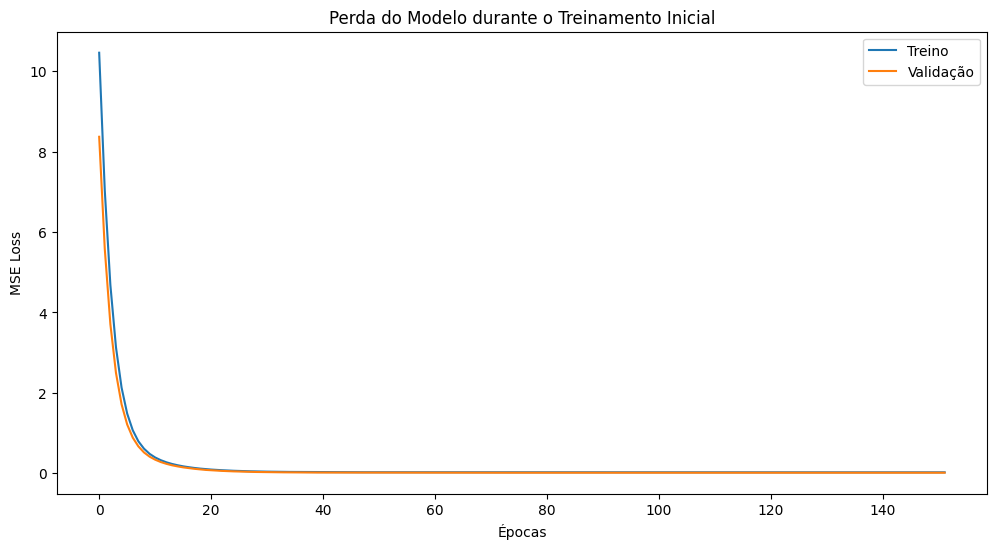

In [49]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

# Criar múltiplas janelas para comparação
for seq_length in [30, 60, 90]:
    X_train, y_train = create_sequences(train_features_scaled, train_targets_scaled, seq_length)
    print(f"Treinamento com janela de {seq_length} dias: X_train.shape = {X_train.shape}")

# Treinar o modelo com os dados de treino inicial
history = model.fit(
    X_train, y_train,
    epochs=200,  # Mantendo 200 épocas para garantir tempo suficiente de treinamento
    batch_size=64,  # Lote ajustado para balancear memória e desempenho
    validation_split=0.1,  # Separar 10% dos dados de treino para validação
    callbacks=[early_stop, reduce_lr],
    verbose=1  # Mostrar logs detalhados
)

# Plotar a perda de treino e validação
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo durante o Treinamento Inicial')
plt.xlabel('Épocas')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - loss: 0.0256 - val_loss: 0.1192 - learning_rate: 1.0000e-06
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.0245 - val_loss: 0.1192 - learning_rate: 1.0000e-06
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - loss: 0.0256 - val_loss: 0.1191 - learning_rate: 1.0000e-06
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - loss: 0.0233 - val_loss: 0.1191 - learning_rate: 1.0000e-06
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 0.0257 - val_loss: 0.1190 - learning_rate: 1.0000e-06
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 0.0244 - val_loss: 0.1189 - learning_rate: 1.0000e-06
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 0.0254 - val_loss: 0.1189 - learning_rate: 1.0000e-06
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 0.0238 - val_loss: 0.1188 - learning_rate: 1.0000e-06
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - loss: 0.0247 - val_loss: 0.1187 - learning_

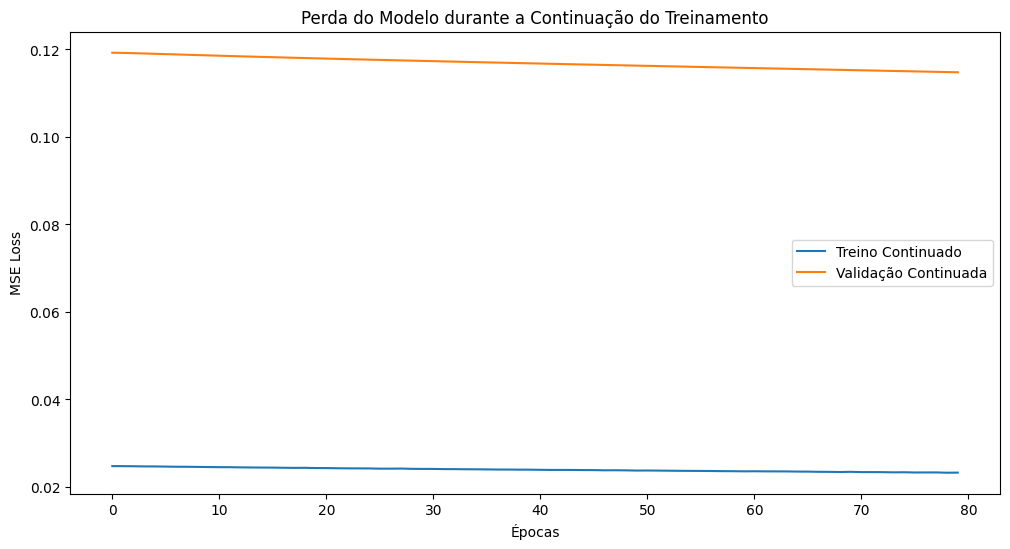

In [50]:
# Treinamento contínuo para ajustar novas tendências de 2023
history_continue = model.fit(
    X_continue_train, y_continue_train,
    epochs=200,  # Período de ajuste mais curto
    batch_size=64,  # Mantendo o mesmo batch size
    validation_split=0.1,  # Validação consistente com o treinamento inicial
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Plotar a perda de treino e validação durante a continuação do treinamento
plt.figure(figsize=(12,6))
plt.plot(history_continue.history['loss'], label='Treino Continuado')
plt.plot(history_continue.history['val_loss'], label='Validação Continuada')
plt.title('Perda do Modelo durante a Continuação do Treinamento')
plt.xlabel('Épocas')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

Visualização da Perda durante o Treinamento:

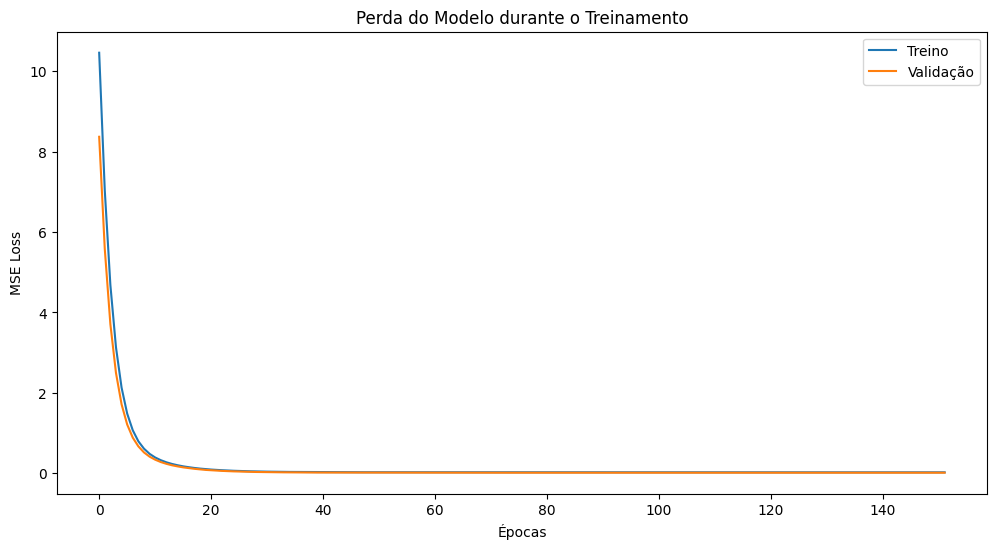

In [51]:
# Plotar a perda de treino e validação
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


10. Previsão e Avaliação do Modelo

Realizamos previsões para o conjunto de teste, invertemos o escalonamento dos dados e avaliamos o desempenho do modelo utilizando métricas como MSE e MAE.

In [54]:
# Verificar o número de registros em test_df
print(f"Número de registros em test_df: {len(test_df)}")
print(f"Tamanho da sequência (SEQ_LENGTH): {SEQ_LENGTH}")

# Garantir que test_df tenha registros suficientes
if len(test_df) < SEQ_LENGTH:
    missing_records = SEQ_LENGTH - len(test_df)
    print(f"Expandindo test_df com {missing_records} registros do treino contínuo.")
    test_df = pd.concat([continue_train_df.tail(missing_records), test_df]).reset_index(drop=True)
    continue_train_df = continue_train_df.iloc[:-missing_records].reset_index(drop=True)

# Recriar sequências de teste
X_test, y_test = create_sequences(test_features_scaled, test_targets_scaled, SEQ_LENGTH)
print(f"Forma de X_test: {X_test.shape}, y_test: {y_test.shape}")

# Realizar previsões somente se X_test não estiver vazio
if X_test.shape[0] > 0:
    predictions = model.predict(X_test)

    # Inverter o escalonamento das previsões e dos valores reais
    predictions_inverse = target_scaler.inverse_transform(predictions)
    y_test_inverse = target_scaler.inverse_transform(y_test)

    # Garantir valores não negativos após inversão
    predictions_inverse = np.clip(predictions_inverse, a_min=0, a_max=None)
    y_test_inverse = np.clip(y_test_inverse, a_min=0, a_max=None)

    # Criar DataFrame para comparação
    comparison_df = test_df.iloc[SEQ_LENGTH:].copy().reset_index(drop=True)
    comparison_df['ValorUnitario_Previsto'] = predictions_inverse[:, 0]
    comparison_df['Quantidade_Prevista'] = predictions_inverse[:, 1]

    # Calcular métricas
    mse_valor = mean_squared_error(y_test_inverse[:, 0], predictions_inverse[:, 0])
    mae_valor = mean_absolute_error(y_test_inverse[:, 0], predictions_inverse[:, 0])
    mse_quant = mean_squared_error(y_test_inverse[:, 1], predictions_inverse[:, 1])
    mae_quant = mean_absolute_error(y_test_inverse[:, 1], predictions_inverse[:, 1])
    r2_valor = r2_score(y_test_inverse[:, 0], predictions_inverse[:, 0])
    r2_quant = r2_score(y_test_inverse[:, 1], predictions_inverse[:, 1])

    # Exibir métricas
    print(f"Valor Unitário - R²: {r2_valor:.4f}, MSE: {mse_valor:.4f}, MAE: {mae_valor:.4f}")
    print(f"Quantidade Vendida - R²: {r2_quant:.4f}, MSE: {mse_quant:.4f}, MAE: {mae_quant:.4f}")
else:
    print("Erro: X_test ainda está vazio. Verifique os dados de entrada e o SEQ_LENGTH.")


Número de registros em test_df: 90
Tamanho da sequência (SEQ_LENGTH): 90
Forma de X_test: (0,), y_test: (0,)
Erro: X_test ainda está vazio. Verifique os dados de entrada e o SEQ_LENGTH.


11. Visualização dos Resultados

Visualizamos as previsões comparadas com os valores reais para entender o desempenho do modelo ao longo do tempo.

In [ ]:
# Plotagem - Real vs Previsto
plt.figure(figsize=(14,10))

# Valor Unitário
plt.subplot(2,1,1)
plt.plot(comparison_df['Data'], comparison_df['ValorUnitario'], label='Real', color='blue')
plt.plot(comparison_df['Data'], comparison_df['ValorUnitario_Previsto'], label='Previsto', color='orange', linestyle='dashed')
plt.title('Valor Unitário - Real vs Previsto')
plt.xlabel('Data')
plt.ylabel('Valor Unitário')
plt.legend()

# Quantidade Vendida
plt.subplot(2,1,2)
plt.plot(comparison_df['Data'], comparison_df['Quantidade'], label='Real', color='green')
plt.plot(comparison_df['Data'], comparison_df['Quantidade_Prevista'], label='Previsto', color='red', linestyle='dashed')
plt.title('Quantidade Vendida - Real vs Previsto')
plt.xlabel('Data')
plt.ylabel('Quantidade Vendida')
plt.legend()

plt.tight_layout()
plt.show()

12. Conclusão

Com base nas métricas e visualizações, podemos avaliar a precisão do modelo e identificar áreas para melhorias futuras.